In [1]:
#!pip install CommonRegex
#!pip install pgeocode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pytesseract 
from PIL import Image, ImageOps
import re
from commonregex import CommonRegex
import pgeocode
from nltk.corpus import words
import os

texts_df = pd.read_csv('texts.csv')
folder=(r"images/large-receipt-image-dataset-SRD")


In [3]:
print(texts_df['0'][0])

    
  
  
  

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(S62) 597-0906

Server: Francis Station: 4
Order #: 69923 Dine In
Table: B11 Guests: 2
1 Coffee 3.00
2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1:

TOTAL: $56.58

5/26/2016 12:53:10 PM

INAH

THANK YOU!

 



In [4]:
#Change this function to extract ITEMS (with their respective prices)
"""After geting the prices, locate their boxes, search for boxes that have similar height, assume those are 
the names of the items. Then look for the largest box (or the box on top), assume those are the names of the shops). """

def extract_prices(text):
    prices = CommonRegex(text).prices
    if len(prices) > 0:
        return max(prices)
    else:
        return np.nan

In [5]:
def extract_geo(text):
    #zip_code 
    us_zip = r'(\d{5}\-?\d{0,4})'
    zip_code = re.search(us_zip, text)
    try:
        zip_code = zip_code[0]
        nomi = pgeocode.Nominatim('us')
        geodata = nomi.query_postal_code(zip_code)
        longitude = geodata['longitude']
        latitude = geodata['latitude']
    except:
        zip_code = np.nan
        longitude = np.nan
        latitude = np.nan
        
    
    address = CommonRegex(text).street_addresses
    if len(address) == 1:
        address =  address[0]
    else:
        address = np.nan

        
    return zip_code, longitude, latitude, address
    
    

In [6]:
def extract_time(text):
    times = CommonRegex(text).times
    if len(times) == 1:
        return times[0]
    else:
        return np.nan

In [7]:
#texts_df = pd.read_csv('texts.csv')
geos = []
times = []
for text in texts_df['0']:
    times.append(extract_time(text))
    geos.append(extract_geo(text))



In [8]:
df = pd.DataFrame(data = geos, columns = ['Zipcode','Latitude', 'Longitude', 'Address' ])
df['Time'] = times
df

,Zipcode,Latitude,Longitude,Address,Time
0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,12:53
1,NaN,NaN,NaN,NaN,NaN
2,378752,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,11:19 AM
...,...,...,...,...,...
195,NaN,NaN,NaN,1805 Parker RD,NaN
196,NaN,NaN,NaN,NaN,6:06
197,002004306,NaN,NaN,NaN,12:41
198,33140,-80.1337,25.8198,1 4959 6ST,8:03PM


In [9]:
prices = []
for text in texts_df['0']:
    prices.append(extract_prices(text))
df['prices'] = prices


#database = df.explode('prices')
#database.reset_index(inplace = True)

In [10]:
df.head()

,Zipcode,Latitude,Longitude,Address,Time,prices
0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,12:53,$56.58
1,NaN,NaN,NaN,NaN,NaN,NaN
2,378752,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,11:19 AM,$8.39


180

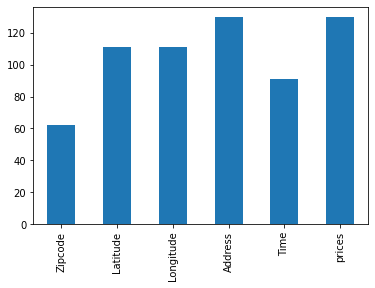

In [11]:
df.isna().sum().plot(kind = 'bar')
sum(df.T.isna().any())

In [12]:


def extract_store_names(folder):
    
    #Iterate through every image text in dataset
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


    stores = []
    for file in os.listdir(folder):
        if file[-3:] == 'jpg':
        #opening the image
            im=Image.open(folder + '//' + file)
            config = ('-l eng --oem 1 --psm 3')

            #obtain boxes of 1 image
            boxes = pytesseract.image_to_data(im,output_type=pytesseract.Output.DATAFRAME)

            #drop boxes with nan texts
            boxes = boxes[boxes['text'].isna() == False]
            #sort by 'top' value from lowest to highest
            boxes.sort_values(by = 'top', inplace = True)
            #check for the lowest box that has an actual word
            store_name = []
            counter = 0
            while store_name == []:
                if counter >= len(boxes):
                    store_name = ''
                    break
                top_word = boxes.iloc[counter]
                if top_word['text'].isalnum():
                    margin = top_word['top'] * 1.05

                    filtered_boxes = boxes[boxes['top']<margin].sort_values(by = 'left')
                    for entry in filtered_boxes['text']:
                        rest_of_title = entry
                        if rest_of_title.isalnum():
                            store_name.append(rest_of_title)
                    store_name = ' '.join(store_name)
                else:
                    counter +=1

            stores.append(store_name)
        
    #return the text in that box
    return stores

In [13]:
stores = extract_store_names(folder)
df['Store Names'] = stores

In [14]:
df.to_csv('structured_data.csv')